In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter,
import matplotlib.ticker as ticker


from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

import seaborn as sns
import autograd.numpy as np
from autograd import grad, elementwise_grad,jacobian, hessian
import pandas as pd
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import load_breast_cancer
plt.rcParams['font.size'] = 14


In [19]:
def Sigmoid(y):
    return np.exp(y)/(1+np.exp(y))
def Identity(y):
    return y

def RELU(y):
    return np.maximum(0,y)
### The best RELU
def lexyRelu(y):
    return np.maximum(0.01*y,y)

def Set_weights_and_bias(n_in,n_hidden,n_out):
#### Setting hiden weights
    W_hidden = 0.1*np.random.randn(n_in, n_hidden)
    b_hidden = np.zeros(n_hidden) +0.01
#### setting output weights
    W_out = 0.1*np.random.randn(n_hidden, n_out)
    b_out = np.zeros(n_out) +0.01
    return W_hidden, W_out, b_hidden, b_out

#### From lecture notes, not in use
def feed_forward_train(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
#### Hidden attac
    z_h = X@W_hidden + b_hidden
    a_h = activation_function(z_h)
#### output attac
    z_o = a_h@W_out + b_out
    a_o = output_function(z_o)
    return a_h, a_o, z_h,z_o

### Feed forward that returns a scalar
def feed_forward(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
#### Hidden attac
    z_h = X@W_hidden + b_hidden
    a_h = activation_function(z_h)
#### output attac
    z_o = a_h@W_out + b_out
    a_o = output_function(z_o)
    return a_o[0]
#### Feed forward that returns a 6X1 vector, important for making the matrix multiplication work
def feed_forward_eigen(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
#### Hidden attac
 #   print(X)
#    print(W_hidden)
    z_h = X@W_hidden + b_hidden
    a_h = activation_function(z_h)
#### output attac
    z_o = a_h@W_out + b_out
    a_o = output_function(z_o)
 #   print(a_o)
    a_o = a_o.reshape(6,1)
    return a_o

def u(x):
    return np.sin(np.pi*x)

### trialfunction for heat equation, from notes
def g_trial(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
    x,t = X[0],X[1]
    return (1)*u(x) + x*(1-x)*t*feed_forward(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)

#### From notes
### trialfunction for heat
def cost_function(x,t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function):
    cost_sum = 0
    
    g_t_jac_fun = jacobian(g_trial)
    g_t_hessian_fun = hessian(g_trial)
    
    for x_ in x:
        for t_ in t:
            X = np.array([x_,t_])
            g_t = g_trial(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            g_t_jac = g_t_jac_fun(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            g_t_hessian =g_t_hessian_fun(X,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            g_t_dt = g_t_jac[1]
            g_t_d2x = g_t_hessian[0][0]
            
            error = g_t_dt -g_t_d2x
            cost_sum += error**2
    return cost_sum/(np.size(x)*np.size(t))

#### trial function for eigenvalue problem
def g_trial_eigen(t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,x_0):
    return x_0 + (feed_forward_eigen(t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function))
#### a function
def eigen_func(g_t,A):
    return (g_t.T@g_t)[0] *A@ g_t - (g_t.T@ A @g_t)[0]*g_t  ## Python cant recognice scalars

def cost_function_eigen(t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0):
    g_t_dt_func = elementwise_grad(g_trial_eigen,0)
    square_error =0
    for t_ in t:
        g_t = g_trial_eigen(t_,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,x_0)
        g_t_dt = g_t_dt_func(t_,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,x_0)
     #   print(np.shape(g_t))
        square_error += (g_t_dt - eigen_func(g_t,A))**2
    
    return square_error/np.size(t)

### from notes, altered to fitt our setup
def solution(x,t,N_hidden,eta, activation_function ,output_function, epoch,Minibach):
    W_hidden, W_out, b_hidden, b_out = Set_weights_and_bias(2,N_hidden,1)
 #   print('Initial cost: ', cost_function(x,t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function))
    
    cost_func_wh_grad = elementwise_grad(cost_function,2)
    cost_func_bh_grad = elementwise_grad(cost_function,4)
    cost_func_wo_grad = elementwise_grad(cost_function,3)
    cost_func_bo_grad = elementwise_grad(cost_function,5)
    MiniBachSize =int(np.size(x)/Minibach)
    for e in range(epoch):
        for j in range(Minibach):
            miniBach = np.random.randint(Minibach)
            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            x_bach,t_bach = x[miniBachMin:miniBachMax],t[miniBachMin:miniBachMax]
            W_hidden -= eta*cost_func_wh_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            W_out -= eta*cost_func_wo_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            b_hidden -= eta*cost_func_bh_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            b_out -= eta*cost_func_bo_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
      #  print("finished iteration number: ", e)
   
   # print('Final cost: ', cost_function(x,t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function))
    return W_hidden, W_out, b_hidden, b_out

def solution_eigen(t,N_hidden,eta, activation_function ,output_function, epoch,Minibach,A,x_0):
    W_hidden, W_out, b_hidden, b_out = Set_weights_and_bias(1,N_hidden,6)
    cost_function_eigen(t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
    
    cost_func_wh_grad = elementwise_grad(cost_function_eigen,1)
    cost_func_bh_grad = elementwise_grad(cost_function_eigen,3)
    cost_func_wo_grad = elementwise_grad(cost_function_eigen,2)
    cost_func_bo_grad = elementwise_grad(cost_function_eigen,4)
    MiniBachSize =int(np.size(t)/Minibach)
    for e in range(epoch):
        for j in range(Minibach):
        #    print(j)
            miniBach = np.random.randint(Minibach)
            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            t_bach = t[miniBachMin:miniBachMax]
            W_hidden -= eta*cost_func_wh_grad(t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
            W_out -= eta*cost_func_wo_grad(t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
            b_hidden -= eta*cost_func_bh_grad(t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
            b_out -= eta*cost_func_bo_grad(t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
      #  print("finished iteration number: ", e)
   
   # print('Final cost: ', cost_function(x,t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function))
    return W_hidden, W_out, b_hidden, b_out

def solution_eigen2(t,N_hidden,eta, activation_function ,output_function, epoch,Minibach,A,x_0,W_hidden, W_out, b_hidden, b_out):
    cost_function_eigen(t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
    cost_func_wh_grad = elementwise_grad(cost_function_eigen,1)
    cost_func_bh_grad = elementwise_grad(cost_function_eigen,3)
    cost_func_wo_grad = elementwise_grad(cost_function_eigen,2)
    cost_func_bo_grad = elementwise_grad(cost_function_eigen,4)
    MiniBachSize =int(np.size(t)/Minibach)
    for e in range(epoch):
        for j in range(Minibach):
        #    print(j)
            miniBach = np.random.randint(Minibach)
            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            t_bach = t[miniBachMin:miniBachMax]
            W_hidden -= eta*cost_func_wh_grad(t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
            W_out -= eta*cost_func_wo_grad(t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
            b_hidden -= eta*cost_func_bh_grad(t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
            b_out -= eta*cost_func_bo_grad(t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function,A,x_0)
      #  print("finished iteration number: ", e)
   
   # print('Final cost: ', cost_function(x,t,W_hidden, W_out, b_hidden, b_out,activation_function, output_function))
    return W_hidden, W_out, b_hidden, b_out

#### This one is nice when we want to study how the MSE converges
def Solution2(x,t,N_hidden,eta, epoch,Minibach, W_hidden, W_out, b_hidden, b_out):
    cost_func_wh_grad = elementwise_grad(cost_function,2)
    cost_func_bh_grad = elementwise_grad(cost_function,4)
    cost_func_wo_grad = elementwise_grad(cost_function,3)
    cost_func_bo_grad = elementwise_grad(cost_function,5)
    activation_function = Sigmoid
    output_function = Identity
    MiniBachSize =int(np.size(x)/Minibach)
    for e in range(epoch):
        for j in range(Minibach):
            miniBach = np.random.randint(Minibach)
            miniBachMin, miniBachMax = MiniBachSize * miniBach,(MiniBachSize) * (miniBach+1)
            x_bach,t_bach = x[miniBachMin:miniBachMax],t[miniBachMin:miniBachMax]
            W_hidden -= eta*cost_func_wh_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            W_out -= eta*cost_func_wo_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            b_hidden -= eta*cost_func_bh_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
            b_out -= eta*cost_func_bo_grad(x_bach,t_bach,W_hidden, W_out, b_hidden, b_out,activation_function, output_function)
    return W_hidden, W_out, b_hidden, b_out

Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)
Doing the strap:)


C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:40: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.maximum,     lambda ans, x, y : unbroadcast_f(x, lambda g: g * balanced_eq(x, ans, y)),
C:\ProgramData\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:41: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: g * balanced_eq(y, ans, x)))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in matmul
C:\ProgramData\Anaconda3\lib\site-packages\autograd\core.py:212: RuntimeWarning: invalid value encountered in double_scalars
  def _add(self, x, y):        r

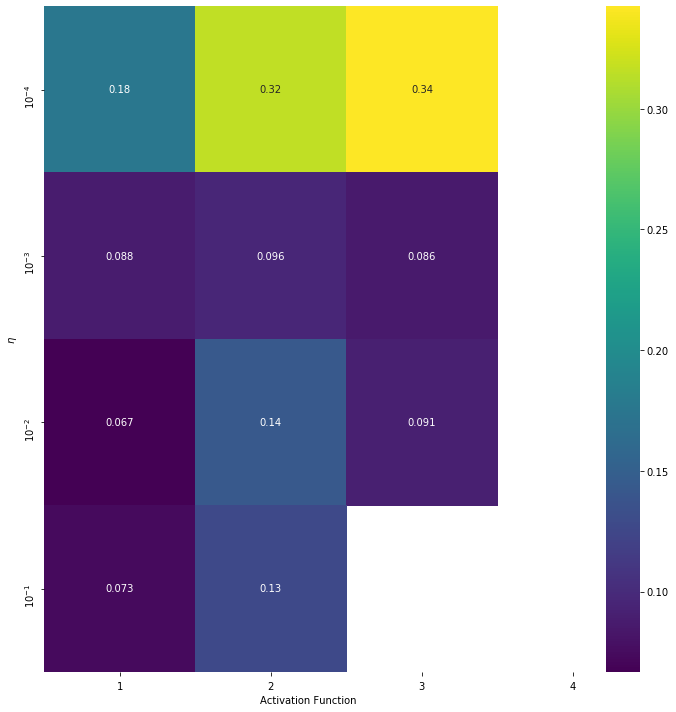

In [3]:
##### We have changed how we test and train.
##### The training is done on a random unsorted grid, while the test is done on a fixed grid
#### We don't do a conventional bootstrap with resampling, but in stead change the entire grid

t_test = np.linspace(0,1,50)
x_test = np.linspace(0,1,50)

etas = np.logspace(-4,-1,4)


activation_functions = [Sigmoid,RELU,lexyRelu]
output_function = Identity
epoch,Minibach = 100, 3
N_hidden = 32
N_straps = 10

error_list = np.zeros((np.size(etas),np.size(activation_functions)))
##### Training our network :)
k,l= 0,0
for eta in etas:
    for activation_function in activation_functions:
        g_error = 0
        print("Doing the strap:)")
        for counter in range(N_straps):
##### In stead of resampling we change the grid
            x = np.random.uniform(0,1,6)
            t = np.random.uniform(0,1,6)
            W_hidden, W_out, b_hidden, b_out = solution(x,t,N_hidden,eta, activation_function ,output_function, epoch,Minibach)
            error = 0
            u_t = np.zeros((50,50))
            i,j= 0,0
            for x_0 in x_test:
                for t_0 in t_test:
                    X_0 = np.array([x_0,t_0])
                    u_t[j,i] = g_trial(X_0,W_hidden, W_out, b_hidden, b_out,Sigmoid, Identity)
                    error += (u_t[j,i]-u(x_0)*np.exp(-np.pi**2*t_0))**2
                    j+=1
                j=0
                i+=1
   #         plt.imshow(u_t,origin='lower')
   #         plt.show()
            error/= (np.size(t_test)*np.size(x_test))
            g_error += error
           # print(error)
        g_error /= N_straps
        error_list[k,l] += g_error
        l+=1
    k+=1
    l= 0 

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in [1,2,3]]
ty = [u"${}$".format(tick.format_data(x)) for x in etas]

#lambdas_sea = [lambdas[i] for i in range(len(lambdas))]
#etas_sea =  [etas[i] for i in range(len(etas))]

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data=error_list,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
ax.set_xlabel(r'Activation Function')
ax.set_ylabel(r'$\eta$')
plt.tight_layout()
plt.savefig(f"Test_Accuracy_Single_hidden_layer.pdf")
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


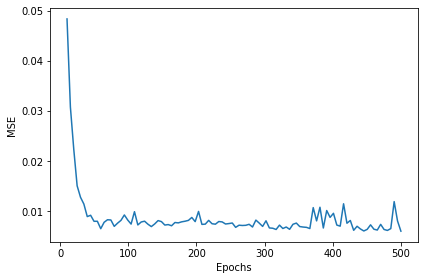

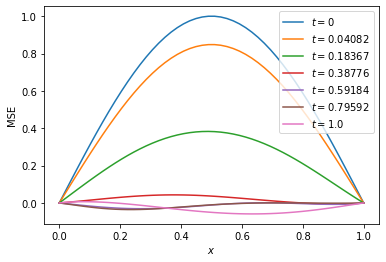

In [18]:
### Solution as function of epochs
x = np.random.uniform(0,1,10)
t = np.random.uniform(0,1,10)

t_test = np.linspace(0,1,50)
x_test = np.linspace(0,1,50)

N_hidden = 32
eta = 0.1
epoch = 5
Minibach = 3

epoch_List = np.linspace(10,500,100)
error_list = np.zeros_like(epoch_List)

W_hidden, W_out, b_hidden, b_out = Set_weights_and_bias(2,N_hidden,1)
for i in range(100):
    W_hidden, W_out, b_hidden, b_out = Solution2(x,t,N_hidden,eta, epoch,Minibach, W_hidden, W_out, b_hidden, b_out)
    error = 0
    u_t = np.zeros((50,50))
    l,j= 0,0
    for x_0 in x_test:
        for t_0 in t_test:
            X_0 = np.array([x_0,t_0])
            u_t[j,l] = g_trial(X_0,W_hidden, W_out, b_hidden, b_out,Sigmoid, Identity)
            error += (u_t[j,l]-u(x_0)*np.exp(-np.pi**2*t_0))**2
            j+=1
        j=0
        l+=1
#         plt.imshow(u_t,origin='lower')
#         plt.show()
    error/= (np.size(t_test)*np.size(x_test))
    error_list[i] = error
    print(i)
    
plt.plot(epoch_List,error_list)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.tight_layout()
plt.savefig('MSE as a fucntin of epochs.pdf')
plt.show()

plt.plot(x_test, u_t[0,:],label=r'$t=0$')
plt.plot(x_test, u_t[2,:],label= r'$t=$' + str(round(t_test[2],5)))
plt.plot(x_test, u_t[9,:],label= r'$t=$' + str(round(t_test[9],5)))
plt.plot(x_test, u_t[19,:],label= r'$t=$' + str(round(t_test[19],5)))
plt.plot(x_test, u_t[29,:],label= r'$t=$' + str(round(t_test[29],5)))
plt.plot(x_test, u_t[39,:],label= r'$t=$' + str(round(t_test[39],5)))
plt.plot(x_test, u_t[49,:],label= r'$t=$' + str(round(t_test[49],5)))
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel('MSE')
plt.savefig('Cross-section_NN')
plt.show()



0.39261517402904256 0.16922454248244997


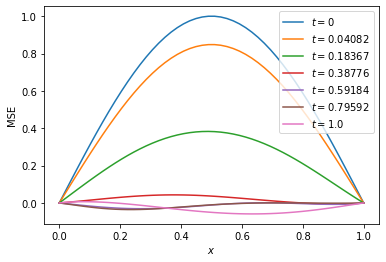

In [20]:
x_0,t_0 = 1/2,0.18
print(g_trial(np.array([x_0,t_0]),W_hidden, W_out, b_hidden, b_out,Sigmoid, Identity),u(x_0)*np.exp(-np.pi**2*t_0) )




plt.plot(x_test, u_t[0,:],label=r'$t=0$')
plt.plot(x_test, u_t[2,:],label= r'$t=$' + str(round(t_test[2],5)))
plt.plot(x_test, u_t[9,:],label= r'$t=$' + str(round(t_test[9],5)))
plt.plot(x_test, u_t[19,:],label= r'$t=$' + str(round(t_test[19],5)))
plt.plot(x_test, u_t[29,:],label= r'$t=$' + str(round(t_test[29],5)))
plt.plot(x_test, u_t[39,:],label= r'$t=$' + str(round(t_test[39],5)))
plt.plot(x_test, u_t[49,:],label= r'$t=$' + str(round(t_test[49],5)))
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel('MSE')
plt.savefig('Cross-section_NN.pdf')
plt.show()





[1.]
[1.e-06 1.e-05 1.e-04 1.e-03 1.e-02]
0
1
2
3
4
5
6
7
8
9
0 1
0
1
2
3
4
5
6
7
8
9
0 2
0
1
2
3
4
5
6
7
8
9
0 3
0
1
2
3
4
5
6
7
8
9
0 4
0
1
2
3
4
5
6
7
8
9
1 1
0
1
2
3
4
5
6
7
8
9
1 2
0
1
2
3
4
5
6
7
8
9
1 3
0
1
2
3
4
5
6
7
8
9
1 4
0
1
2
3
4
5
6
7
8
9
2 1
0
1
2
3
4
5
6
7
8
9
2 2
0
1
2
3
4
5
6
7
8
9
2 3
0
1
2
3
4
5
6
7
8
9
2 4
0
1
2
3
4
5
6
7
8
9
3 1
0
1
2
3
4
5
6
7
8
9
3 2
0
1
2
3
4
5
6
7
8
9
3 3
0
1
2
3
4
5
6
7
8
9
3 4
0
1


C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


2
3
4
5
6
7
8
9
4 1
0
1
2
3
4
5
6
7
8
9


C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)


4 2
0


C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)


1


C:\ProgramData\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: overflow encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:35: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))


2
3
4
5
6
7
8
9
4 3
0
1
2
3
4
5
6
7
8
9
4 4


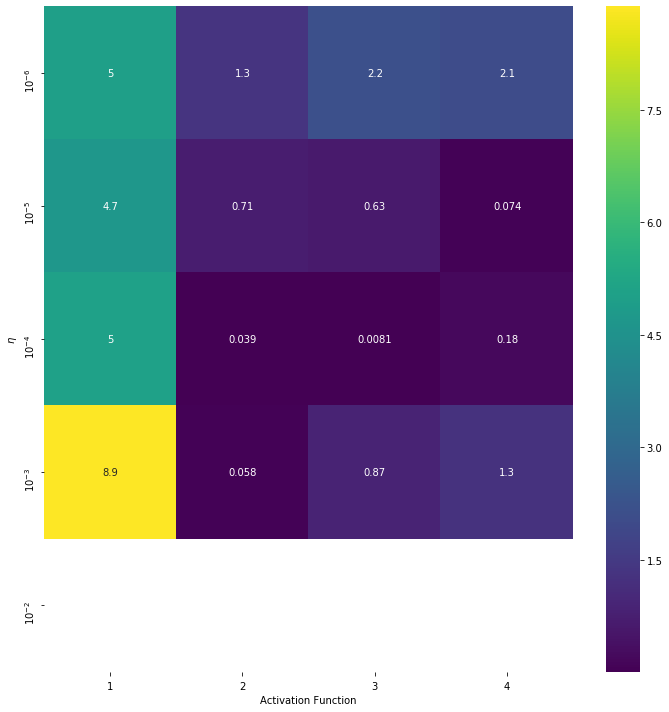

In [3]:


from scipy.linalg import eigvals

t = np.linspace(0,1,30)
t = t.reshape(-1,1)
print(t[-1])
N_hidden = 32
etas = np.logspace(-6,-2,5)
epoch = 100
Minibach = 15
activation_functions = [Sigmoid,RELU,lexyRelu,Identity]
output_function = Identity
N_strap = 10
print(etas)

Eigenvall_error =  np.zeros((np.size(etas),np.size(activation_functions)))

k,l= 0,0
for eta in etas:
    for activation_function in activation_functions:
        g_err = 0
        for counter in range(N_strap):
            print(counter)
    #### in stead of resampling the data points we change the matrix A
            x_0 = np.random.rand(6,1)#np.random.normal(size=(5,1))
            Q = np.random.rand(6,6) 
            A = 1/2 * Q.T @ Q 
            W_hidden, W_out, b_hidden, b_out=solution_eigen(t,N_hidden,eta, activation_function ,output_function, epoch,Minibach,A,x_0)
            g_t = g_trial_eigen([1],W_hidden, W_out, b_hidden, b_out,activation_function, output_function,x_0)
            value =(g_t.T@A@g_t)[0]/ (g_t.T@g_t)[0]
            err = (value - np.sort(np.real(eigvals(A)))[-1])**2
            g_err += err
        Eigenvall_error[k,l] = g_err/N_strap
        l+=1
        print(k,l)
    k+=1
    l=0

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in [1,2,3,4]]
ty = [u"${}$".format(tick.format_data(x)) for x in etas]

#lambdas_sea = [lambdas[i] for i in range(len(lambdas))]
#etas_sea =  [etas[i] for i in range(len(etas))]

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(data=Eigenvall_error,ax=ax, cmap="viridis",annot=True ,xticklabels=tx, yticklabels=ty,)
ax.set_xlabel(r'Activation Function')
ax.set_ylabel(r'$\eta$')
plt.tight_layout()
plt.savefig(f"Max_Egen_error.pdf")
plt.show()


In [266]:
#### note that it is extremly hard to find a network that converges to the smallest eigenvalue, but they 
#### usualy convereg to one eigenvalue
from  numpy.linalg import eig


t = np.linspace(0,1,30)
t = t.reshape(-1,1)
print(t[-1])
N_hidden = 32
eta = 0.0001
activation_function = lexyRelu
output_function= Identity
epoch = 10
Minibach = 15

Q = np.random.uniform(size=(6,6)) 

A = 1/2 * Q.T @ Q 

Eigen,vector = eig(A)

index = np.argmin(Eigen)
#x_0 = vector[:,index]
#x_0 = x_0.reshape(6,1)
x_0 = np.random.rand(6,1)
W_hidden, W_out, b_hidden, b_out=solution_eigen(t,N_hidden,eta, activation_function ,output_function, epoch,Minibach,-A,x_0)

g_t = g_trial_eigen([1],W_hidden, W_out, b_hidden, b_out,activation_function, output_function,x_0)
value =(g_t.T@A@g_t)[0]/ (g_t.T@g_t)[0]

print(Eigen[index],value)

[1.]
-4.431141753352003 [-4.41256035]


[[0.33370515]
 [0.46404459]
 [0.49448273]
 [0.57106561]
 [0.2756114 ]
 [0.76599808]]


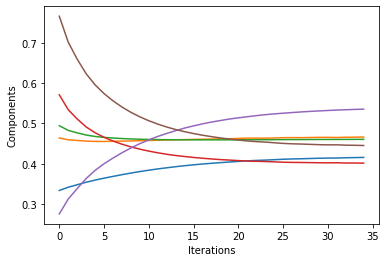

In [271]:
W_hidden, W_out, b_hidden, b_out =  W_hidden, W_out, b_hidden, b_out = Set_weights_and_bias(1,N_hidden,6)
vec_comp = np.zeros((6,35))

vec = g_trial_eigen([1],W_hidden, W_out, b_hidden, b_out,activation_function, output_function,x_0)
print(vec)
for j in range(6):
    vec_comp[j,0]= vec[j,0]



for i in range(34):
    W_hidden, W_out, b_hidden, b_out= solution_eigen2(t,N_hidden,eta, activation_function ,output_function, 1 ,Minibach,-A,x_0,W_hidden, W_out, b_hidden, b_out)
    vec =g_trial_eigen([1],W_hidden, W_out, b_hidden, b_out,activation_function, output_function,x_0)
    for j in range(6):
        vec_comp[j,i+1]= vec[j,0]



true_eigen = vector[:,index]


plt.plot(vec_comp[0,:])
plt.plot(vec_comp[1,:])
plt.plot(vec_comp[2,:])
plt.plot(vec_comp[3,:])
plt.plot(vec_comp[4,:])
plt.plot(vec_comp[5,:])

plt.xlabel('Iterations')
plt.ylabel('Components')
plt.savefig('Component_eigenvector_min.pdf')
plt.show()
